# 🔁 Day 12: Transfer Learning with Pretrained CNNs

In this notebook, we use Transfer Learning with a **pretrained ResNet50 model** to classify images from a subset of the **Cats vs Dogs** dataset.

### Goals:
- Load and preprocess the Cats vs Dogs dataset

- Use ResNet50 with pretrained ImageNet weights

- Freeze the base model and train only the top custom layers

- Evaluate and visualize training and validation performance

In [11]:
# ✅ Imports
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [12]:
# ✅ Download & extract Cats vs Dogs filtered dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=url, extract=True)
base_dir = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')


In [14]:
# ✅ Unzip the dataset
import zipfile
import os

zip_path = "/content/cats_and_dogs_filtered.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ Set directory paths
base_dir = os.path.join(extract_path, "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# ✅ Data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 160
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(train_dir,
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(val_dir,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
# ✅ Load pretrained ResNet50 base (no top layer)
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the convolutional base

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# ✅ Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
# ✅ Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ✅ Train the model
history = model.fit(train_gen,
                    epochs=3,
                    validation_data=val_gen)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='keras')


Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.5872 - loss: 0.6628 - val_accuracy: 0.6140 - val_loss: 0.6592
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6357 - loss: 0.6542 - val_accuracy: 0.6140 - val_loss: 0.6522
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.6189 - loss: 0.6570 - val_accuracy: 0.6180 - val_loss: 0.6491


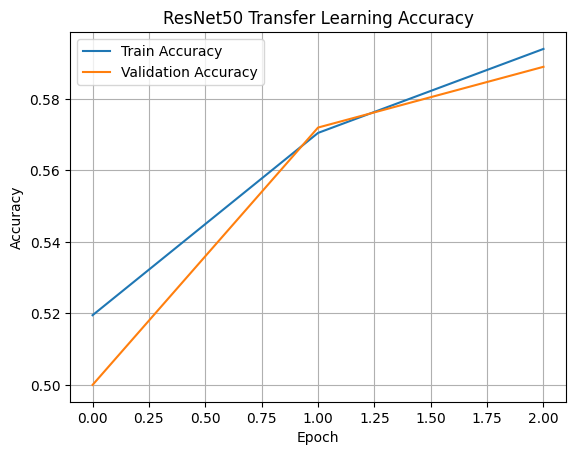

In [18]:
# ✅ Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("ResNet50 Transfer Learning Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

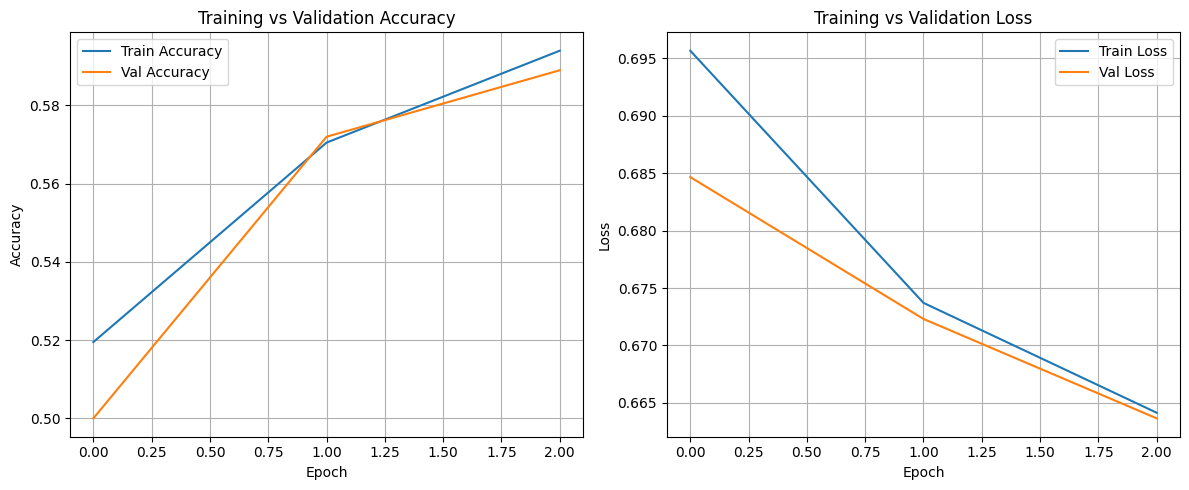

In [19]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Save the figure
plt.tight_layout()
plt.savefig("training_accuracy_loss.png")
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step


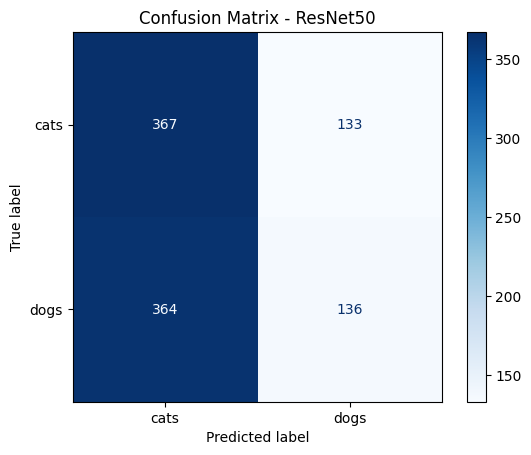

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
val_gen.reset()
y_true = val_gen.classes
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices.keys())

# Plot and save
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - ResNet50")
plt.savefig("confusion_matrix_resnet50.png")
plt.show()

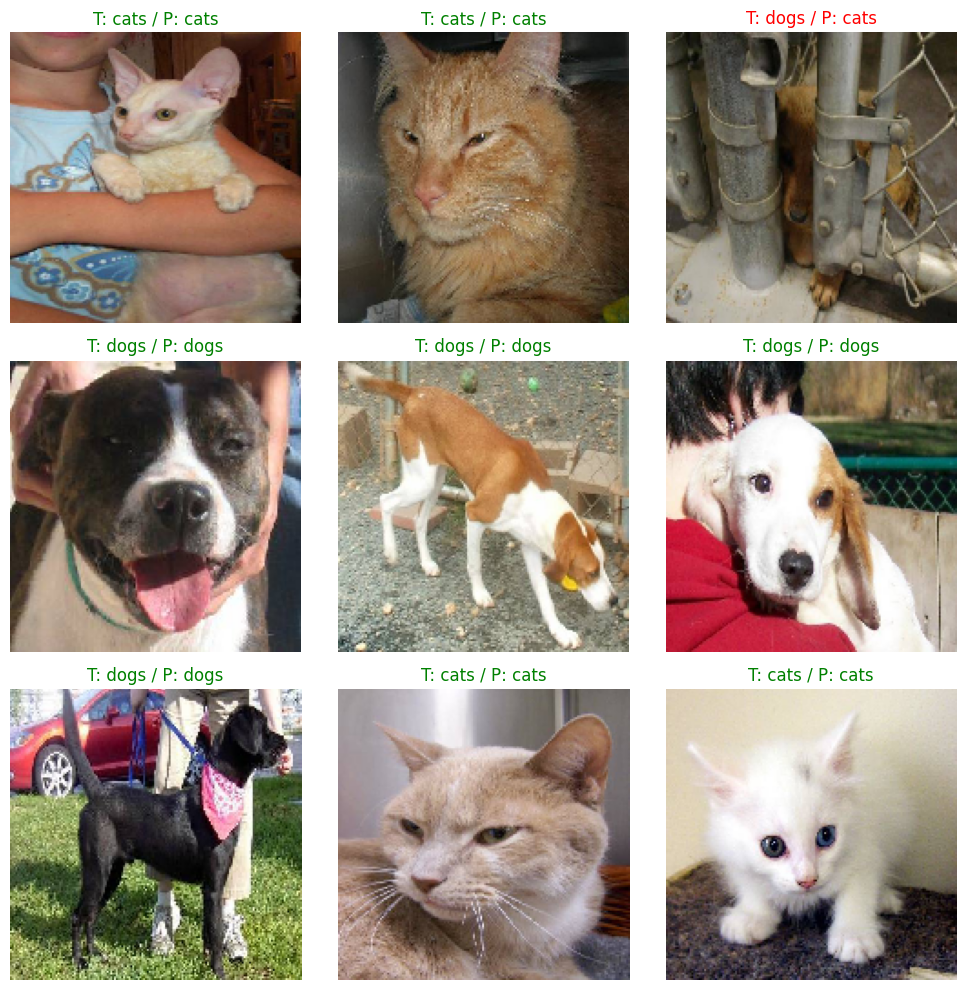

In [23]:
import matplotlib.pyplot as plt

# Show 9 sample predictions
val_gen.reset()
class_names = list(val_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = next(val_gen)  # ✅ Corrected line
    pred = model.predict(img, verbose=0)[0][0]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    plt.axis('off')

    true_label = class_names[int(label[0])]
    predicted_label = class_names[int(pred > 0.5)]

    plt.title(f"T: {true_label} / P: {predicted_label}",
              color="green" if true_label == predicted_label else "red")

plt.tight_layout()
plt.savefig("prediction_grid.png")
plt.show()
